In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#  Load Semi-Synthetic Dataset with Gold Standard Labels

To measure the precision of the different MD methods we created a semi-synthetic
dataset using the first $25$ datasets of an anomaly benchmark [1] and
implanted motif sets of varying sizes $k \in [5, \dots, 10]$ of fixed length $l = 500$. For each method, we used these gold standard parameters
as inputs, i.e. the size $k$ for $k$-Motiflets or the radius $r$ of the implanted
motif set for the competitors. This is one of the datasets

### References
[1] Hoang Anh Dau,Anthony Bagnall,Kaveh Kamgar,Chin-Chia Michael Yeh,Yan Zhu, Shaghayegh Gharghabi, Chotirat Ann Ratanamahatana, and Eamonn Keogh. 2019. The UCR time series archive. IEEE/CAA Journal of Automatica Sinica 6, 6 (2019), 1293–1305.

Dataset Original Length n:  11400
Dataset Sampled Length n:  11400
../datasets/ground_truth/synthetic_gt.csv


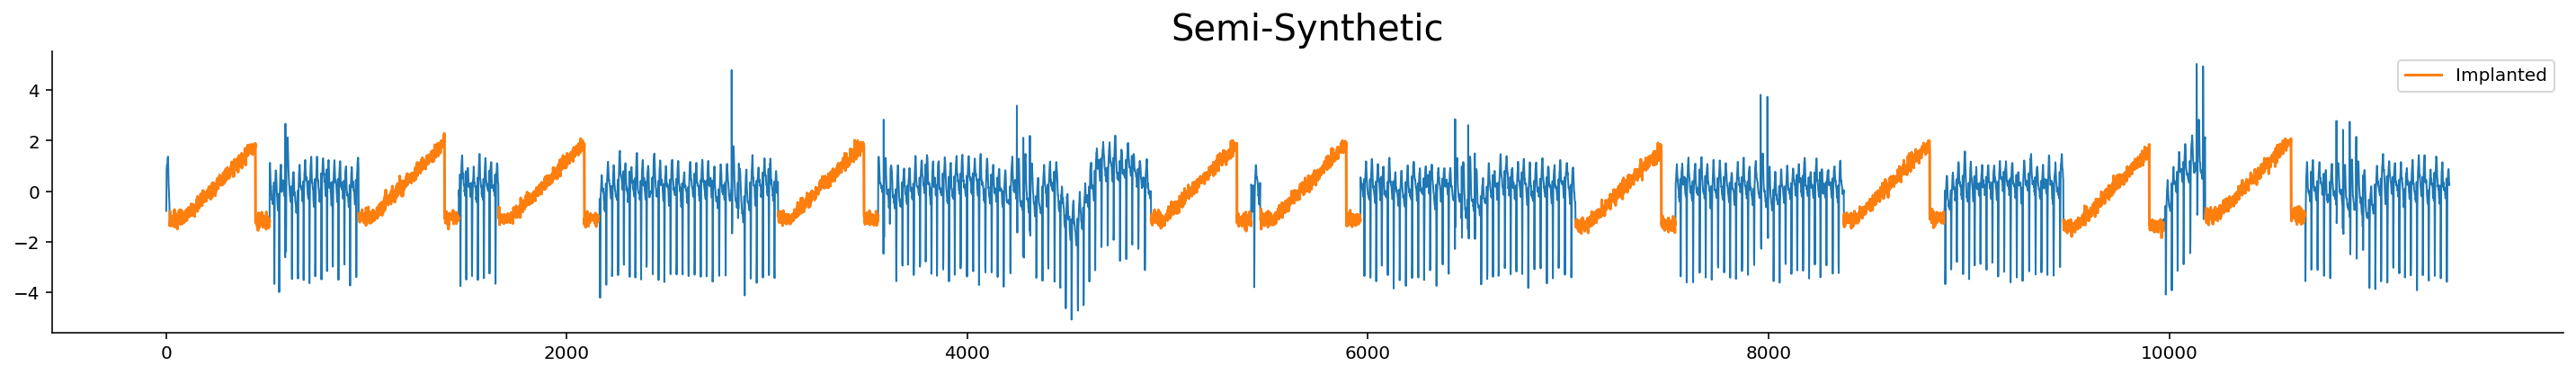

In [2]:
ds_name = "Semi-Synthetic"
file = 'synthetic.csv'

series, df_gt = ml.read_dataset_with_index(file)
plot_dataset(ds_name, series, ground_truth=df_gt)

# Known Motifs

There is one implanted motif with $k=10$ repetitions.

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1 motifs
rerun_all_jars = False
ks=12
motif_length = 500
dataset = os.getcwd() + '/../datasets/' + file

# k-Motiflets

## Next, we learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change.

In the following plots, we one characteristic motif: the implanted motif.

Data 11400


Compute ks (12):   0%|          | 0/10 [00:00<?, ?it/s]

Chosen window-size: 500 in 2.0 s
Elbow Points [10]


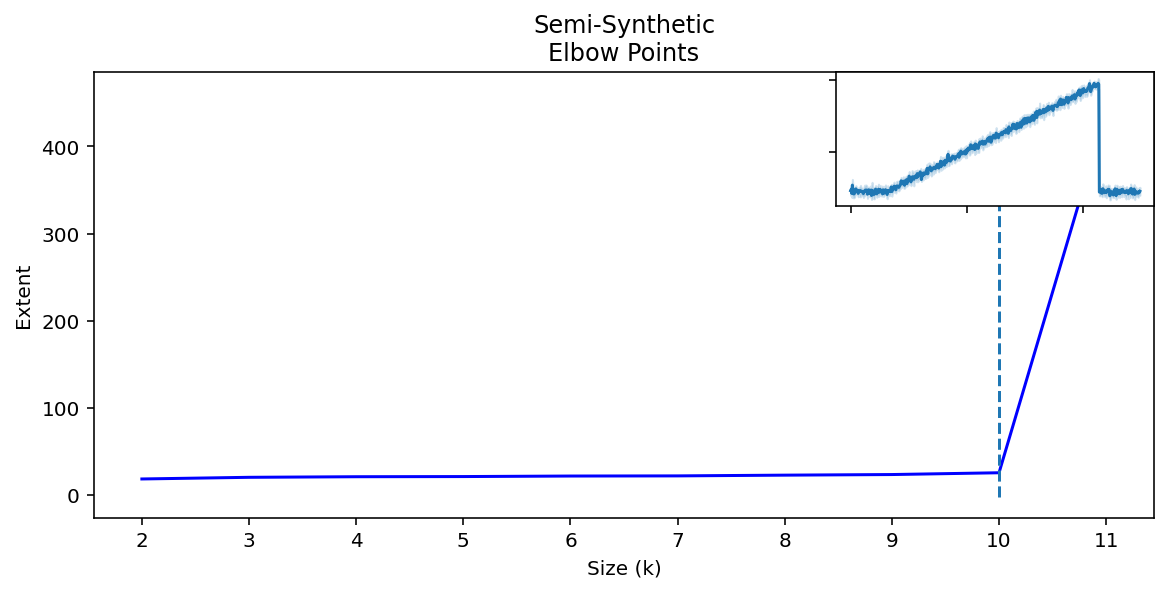

Data 11400


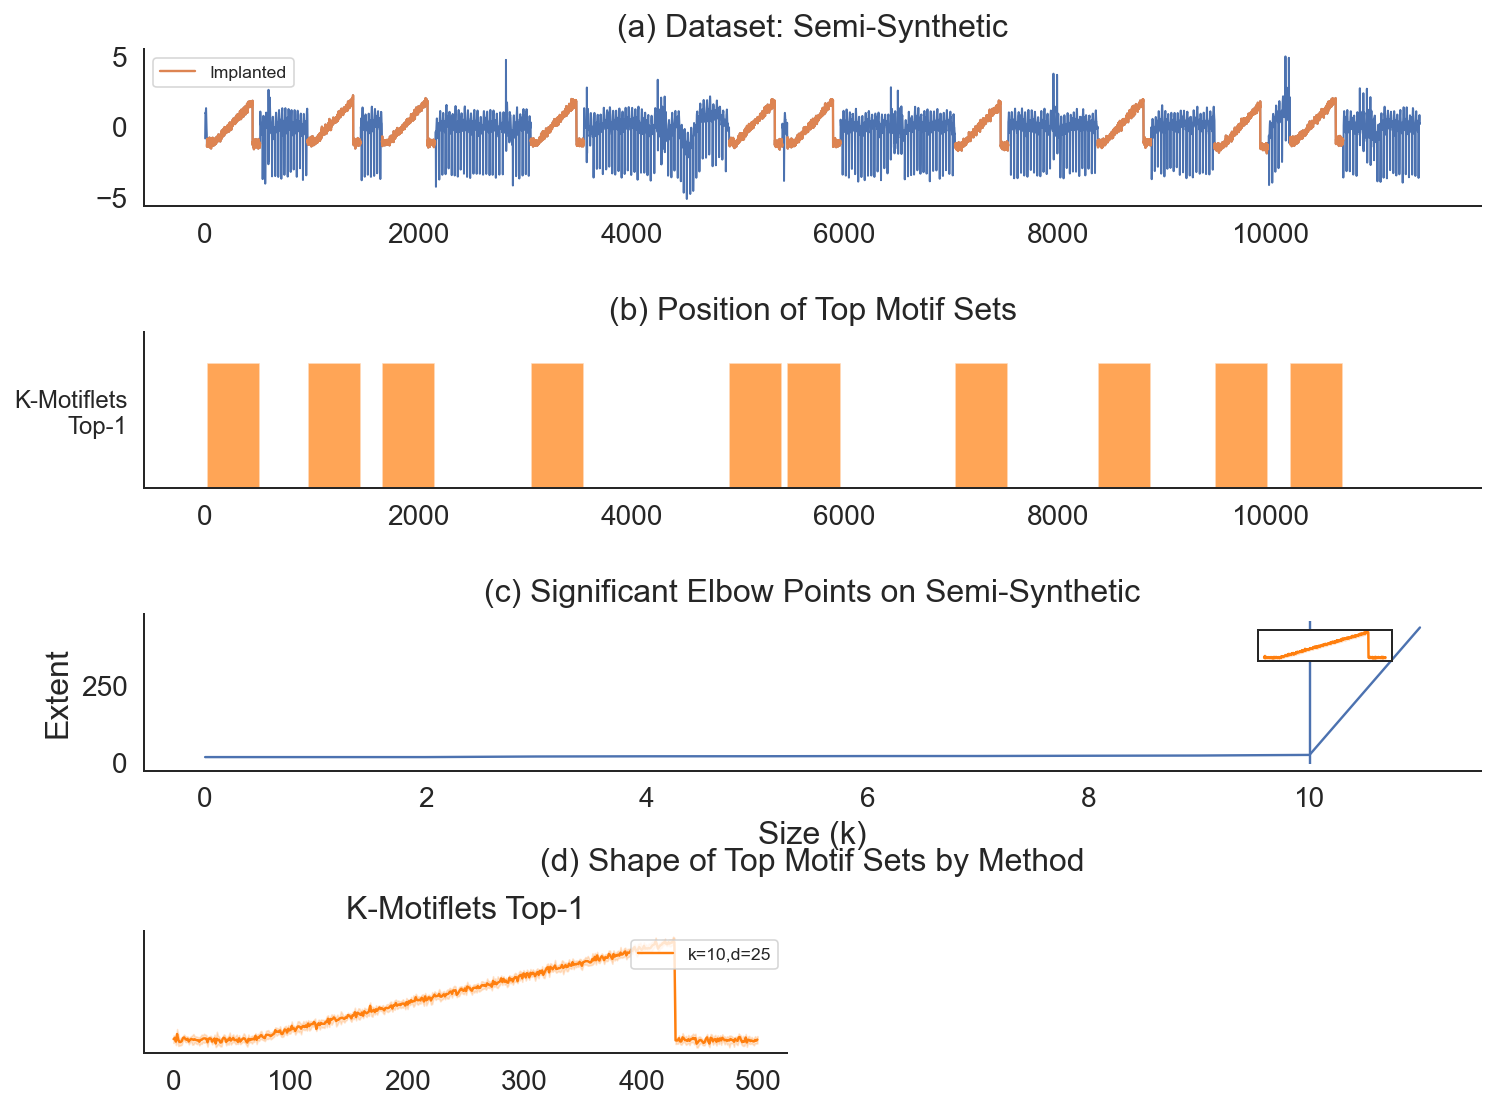

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets", ground_truth=df_gt)

# Oracle

The competitor methods have two input parameters: length l and the radius r. There are derived from the implanted motif.

In [5]:
data = series.values
D_full = ml.compute_distances_full(data, motif_length)
df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])

print("Radius r of TOP-1 Motifs", r_top1)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top1])
print("Radii r", radii)
print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radius r of TOP-1 Motifs 21.242231369018555
Extent d of TOP-1 Motif 25.41066551208496
Radii r [21.24223137]
Best Radii	 [21.24223137]
Best Lengths	 500


# Competitors

We compare our $k$-Motiflets to the state-of-the-art motif set discovery methods. These are based on different definitions as follow:

<img src="images/motif_definitions.png"/>

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [6]:
rs = np.array([r_top1*5])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        # mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

Now, we show the found motifs

,offsets
SF Top-1,"[4, 1643, 3038, 4897, 5442, 7017, 8356, 9456, ..."
SF Top-1 -10%,"[1643, 944, 3035, 4898, 5444, 7014, 8358, 9453..."
SF Top-1 +10%,"[4, 1643, 3038, 4897, 5443, 7017, 8356, 9456, ..."


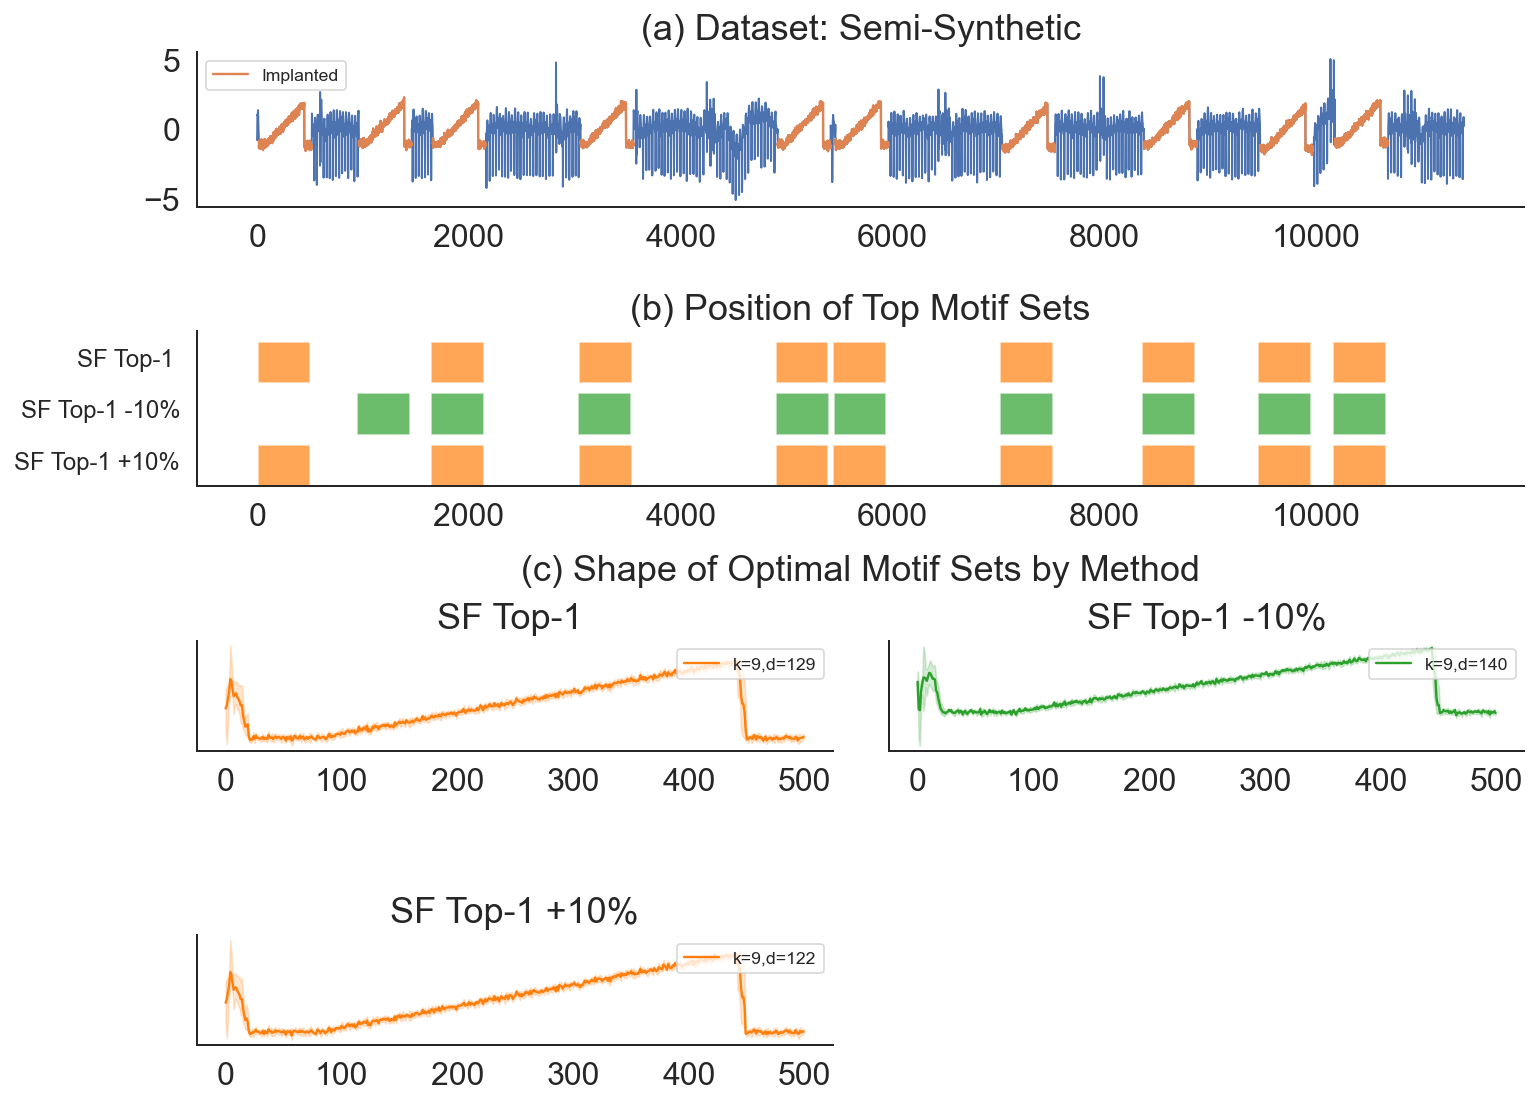

In [7]:
# run jave code first       
ms_all = {
    "" : [
	[4, 1643, 3038, 4897, 5442, 7017, 8356, 9456, 10165],        
    ],
    "-10%" : [
	[1643, 944, 3035, 4898, 5444, 7014, 8358, 9453, 10164],        
    ],
    "+10%" : [
	[4, 1643, 3038, 4897, 5443, 7017, 8356, 9456, 10165],        
    ]
}

motifsets = to_df(ms_all, "SF", df)
display(motifsets)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


Set Finder (SF) found at most $9$ repetitons of the implanted motif set, even given gold standard parameters.

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [8]:
rs = np.array([r_top1*2])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        # mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

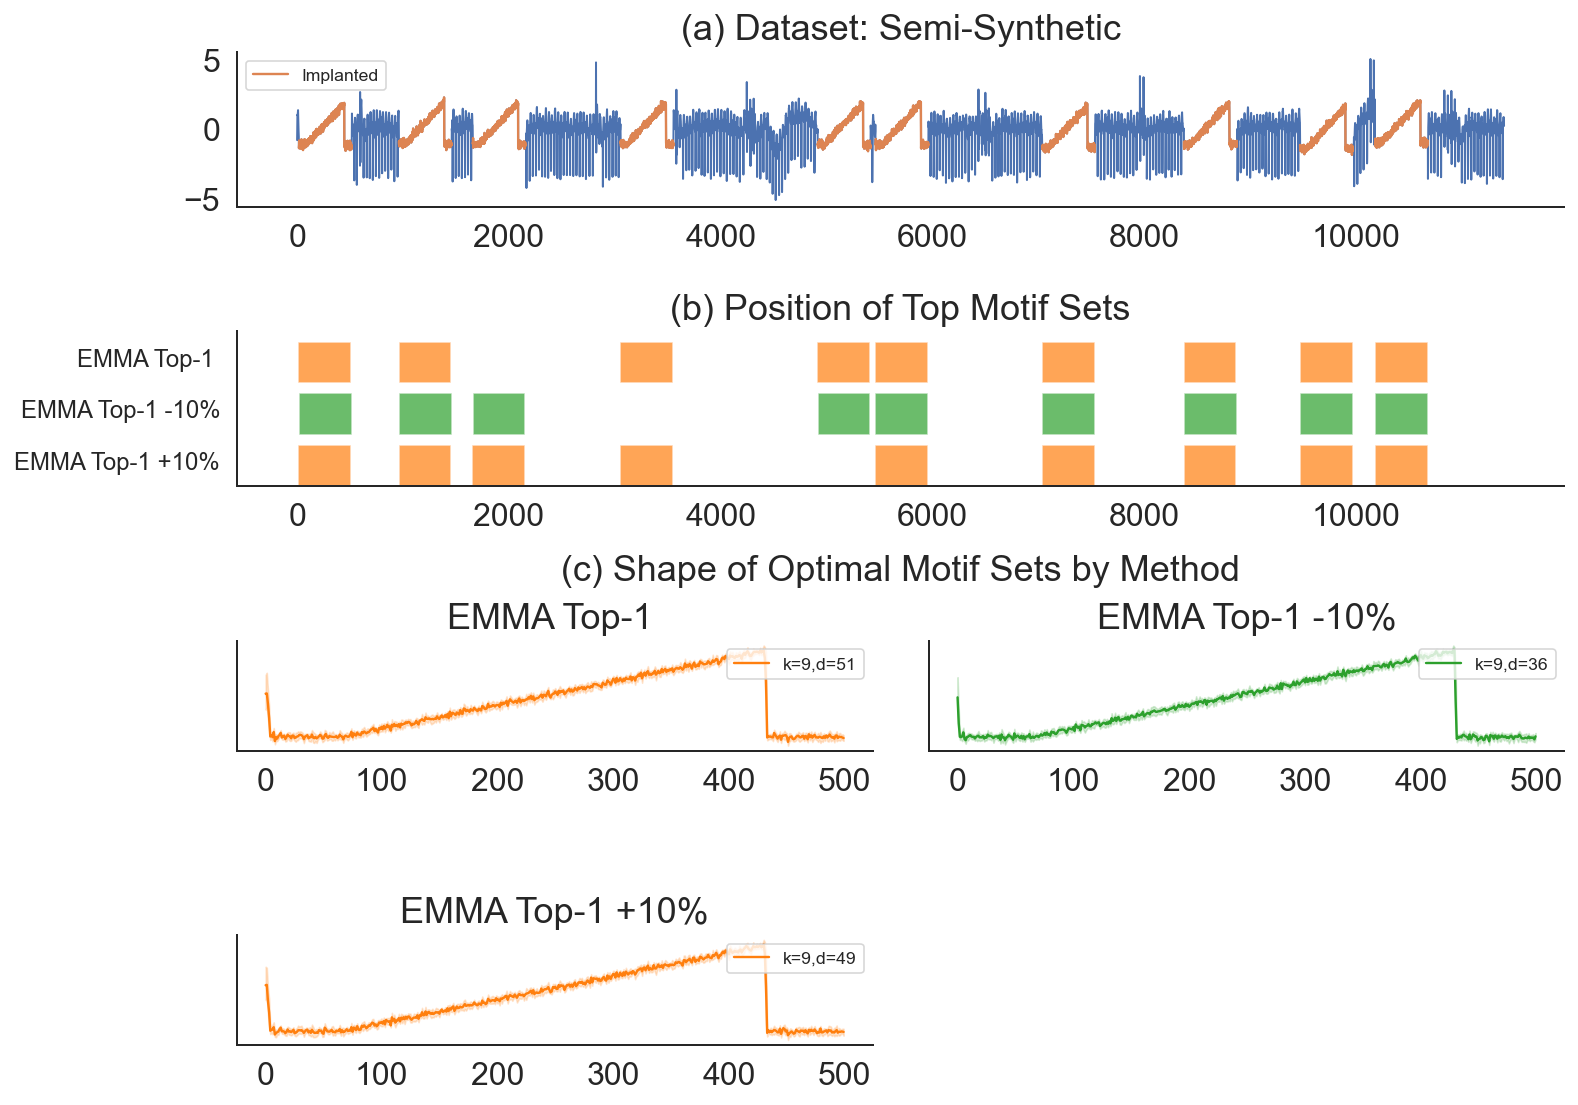

In [9]:
# run jave code first       
ms_all = {
    "" : [
	[13, 958, 3051, 4913, 5459, 7032, 8372, 9469, 10178],        
    ], 
    "-10%" :[
	[15, 960, 1657, 4916, 5462, 7034, 8374, 9471, 10179],
    ],
    "+10%" :[
	[13, 958, 1655, 3051, 5460, 7032, 8372, 9469, 10178],
    ]
}


motifsets = to_df(ms_all, "EMMA", df)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)



EMMA's results are similar to those of SF: only 9 motifs are found.

# Valmod Motif Sets
based on own (fixed-length) implementation

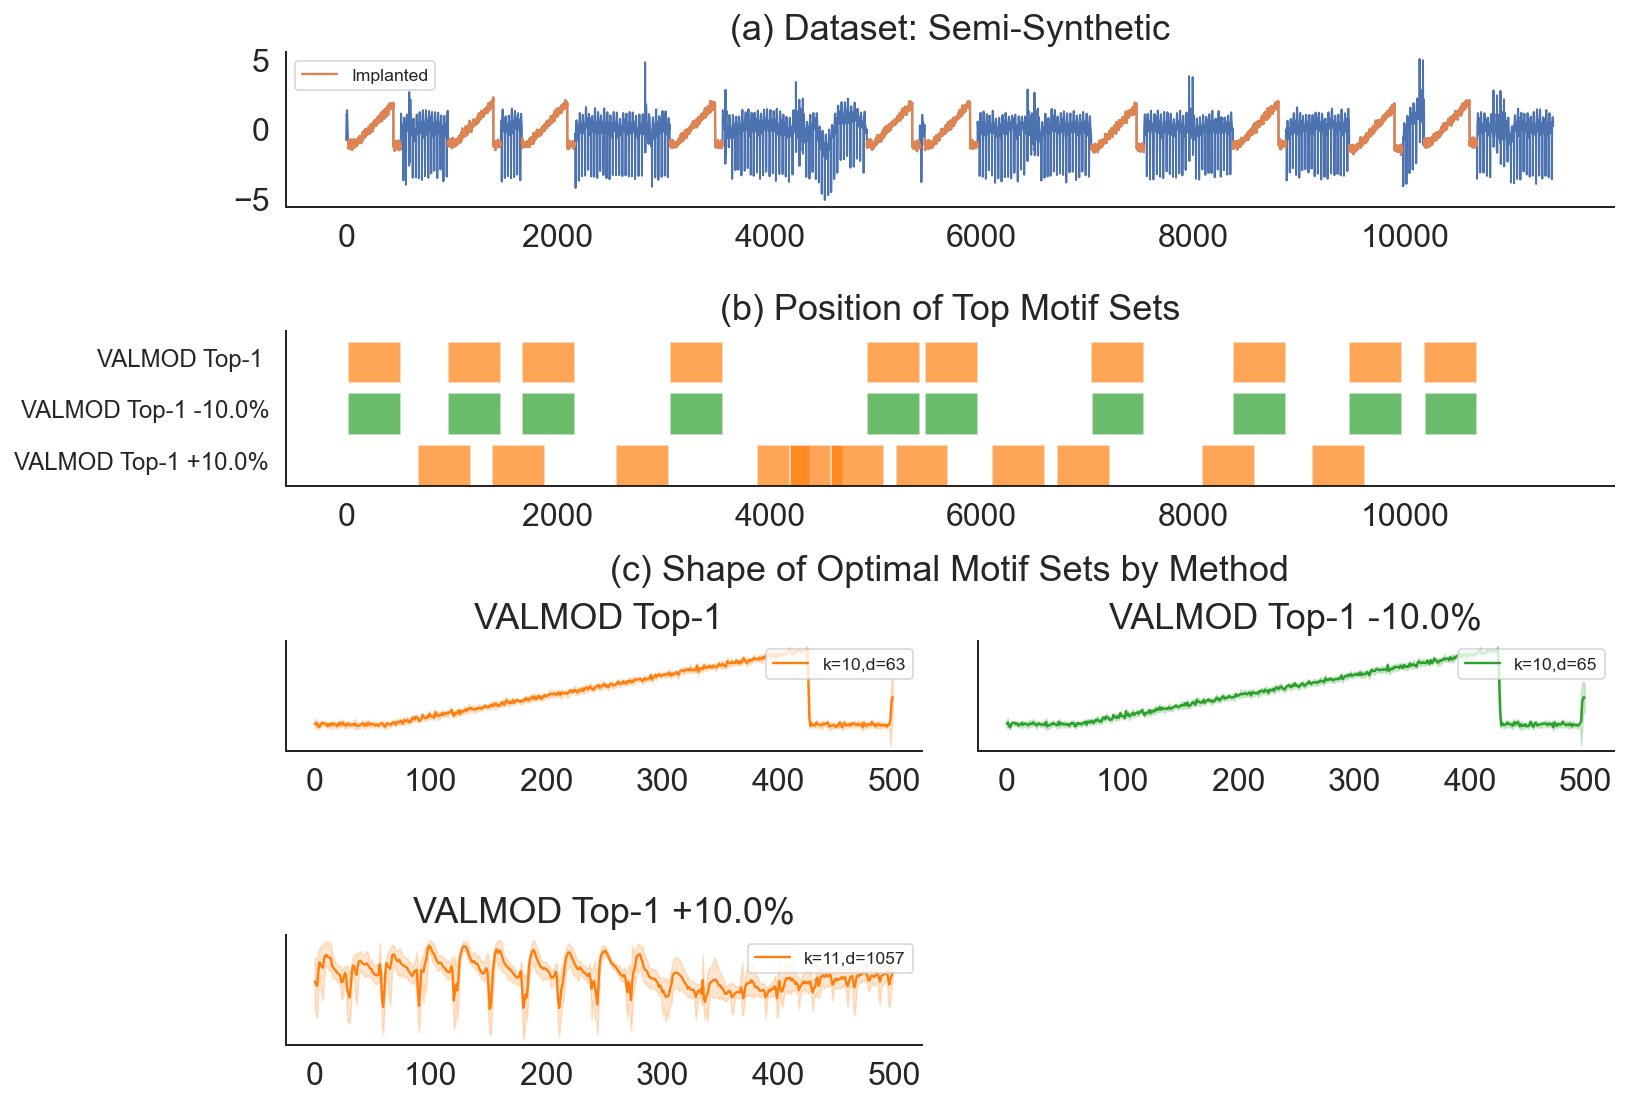

In [10]:
mls = motif_length
max_r=r_top1 * 30

ms_all = {}
for e in errors:
    rs = max_r * (1.0 * (1+e))
    # mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, mls, max_r=rs))
    ms_all[format_key(e)] = ms_valmod
    
    
motifsets = to_df(ms_all, "VALMOD", df)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


VALMOD found all 10 occurences with optimal parameters, yet returns a blurred motif when slightly increasing the radius by 10%.

# Learning Motifs
See Java Code

In [11]:
rs = np.array([r_top1*15])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        # mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

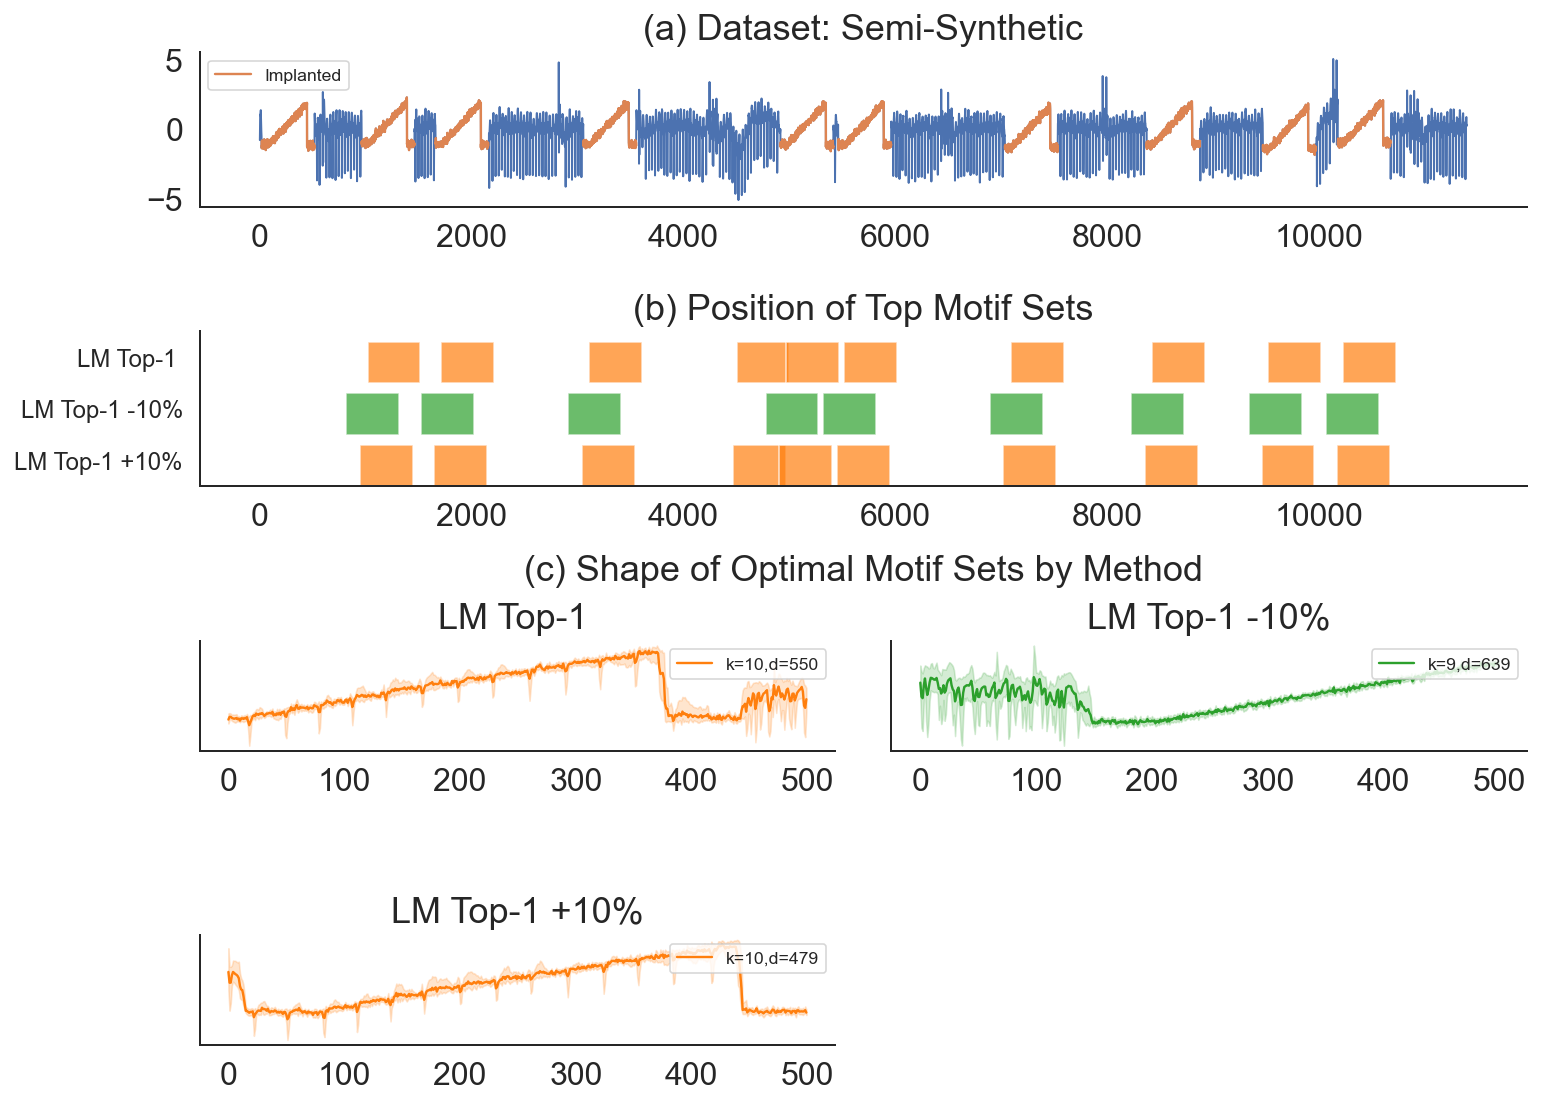

In [12]:
ms_all = {
    "" : [
	[1018,1711,3111,4502,4966,5515,7093,8427,9524,10233,],
    ], 
    "-10%" : [    
	[813,1520,2913,4777,5316,6895,8229,9341,10071,],
    ],        
    "+10%" : [
	[948,1646,3041,4469,4902,5448,7022,8361,9461,10170,],
    ],
}


motifsets = to_df(ms_all, "LM", df)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


Results of LM depend heavily on parameterization and initialization of the stochastic gradient descent (SGD). 
LM found 10 repetitions given optimal parameters, yet returns a blurred motif when decreasing the radius by only 10%.

# Comparison

We next show a comparison of all methods.

Note that the k-Motiflet algorithm has to recover meaningful motifs without any additional knowledge, while the competitors were provided with inputs with near-optimal parameters, and their results rely heavily on parameterization.

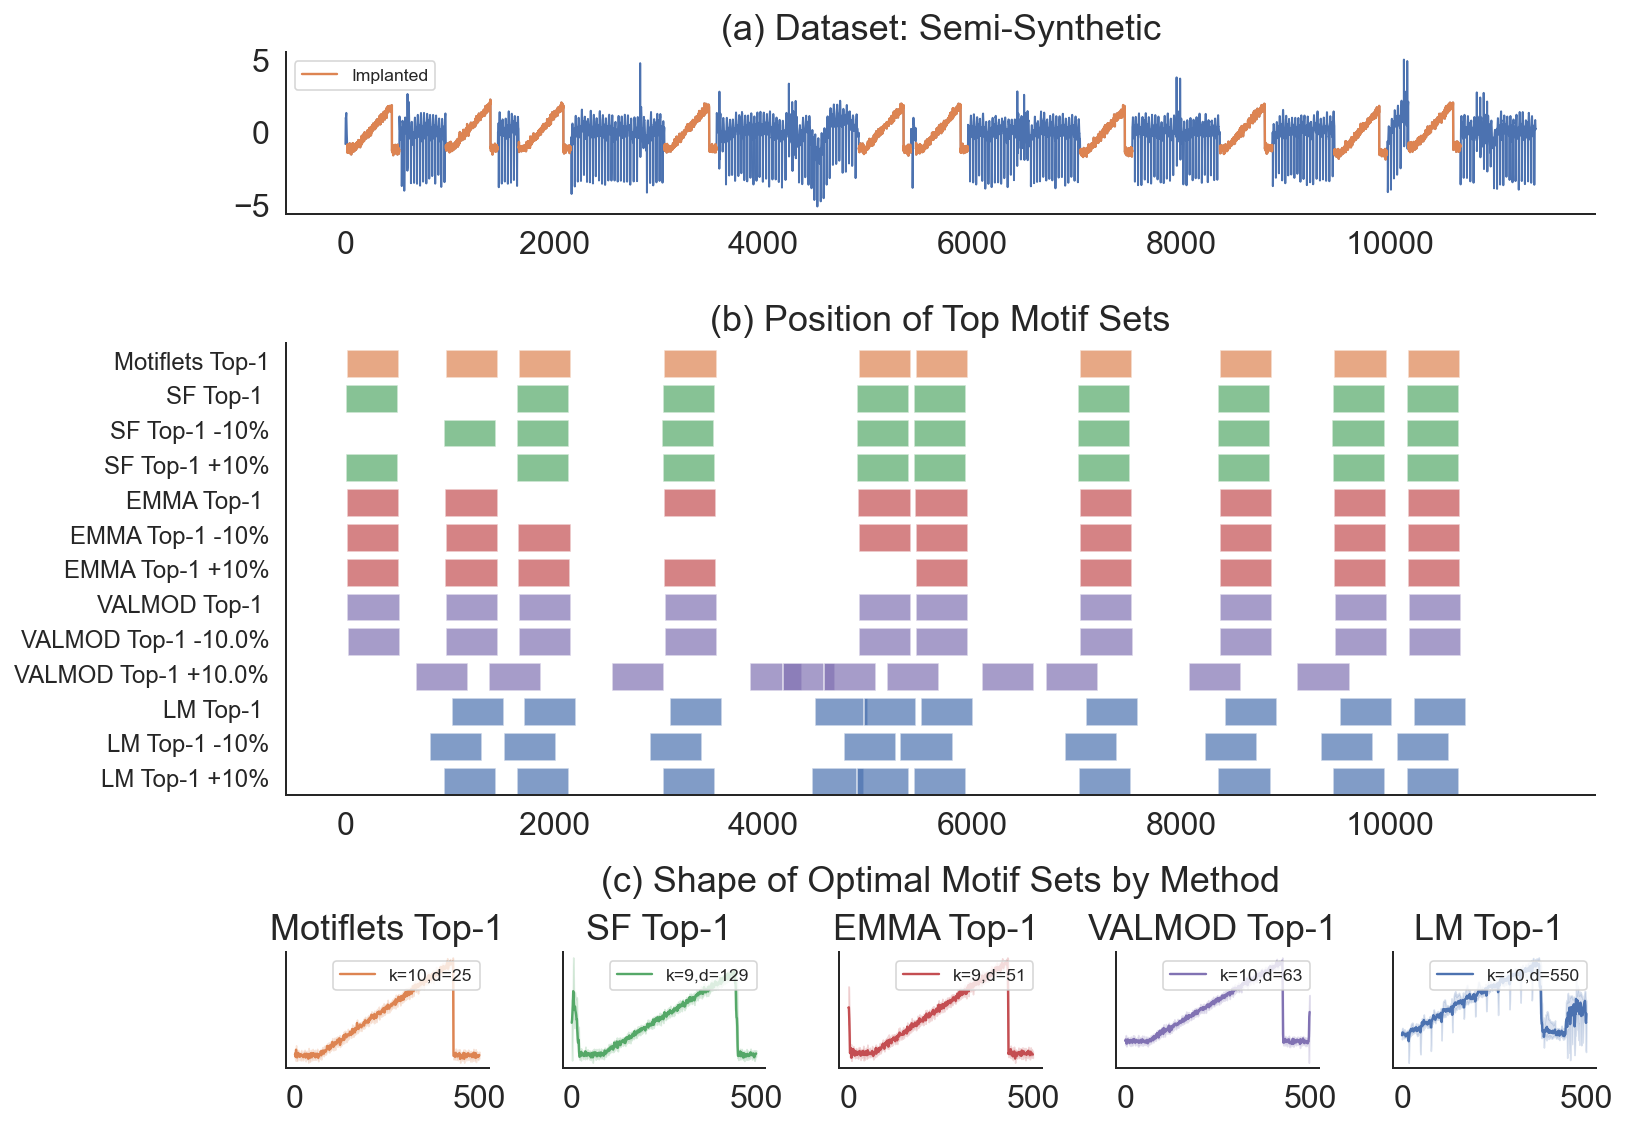

In [13]:
df_all = df.T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, color_palette=color_palette,
                     method_names=df_all.index.values, ground_truth=df_gt, plot_index=plot_index)            

The bottom part of the plot only shows the shape of the optimal motifs, i.e. with optimal parameterization.